# Head tilt features

We present here some code examples for computing IMU-extracted features describing lesion-induced deficits as presented in Fayat et al., 2021.

This notebook must be seen as an illustration of how such analysis can be performed to allow others to use the pipelines rather than code for replicating the exact panels of the paper.

## Imports and data loading

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from madgwick import Madgwick
import angle_visualization
import angle_visualization.triangulation
from SphereProba.distributions import VonMisesFisher as VMF
# Add the helper function folder to the path
import sys
sys.path.append("..")
from imu_helpers import get_immobility, get_angle_x_to_xz, Q_inv_rotate_V
# Column names
col_acc = [f"a{ax}" for ax in "xyz"]  # imu accelerometer [G]
col_gyr = [f"g{ax}" for ax in "xyz"]  # imu gyroscope [deg/s]
col_gravity = [f"aG{ax}" for ax in "xyz"]  # imu gravitational acceleration [G]
col_quaternions = [f"q{ax}" for ax in "wxyz"]
rgb = ["#D55E00", "#009E73", "#0072B2"]  # colors for red, green and blue

In [2]:
# Load an example time series (arsanilate at T=48H after lesion, downsampled to 100Hz)
SR = 100.  # Sampling rate, in Herz
df = pd.read_csv("data/example_arsanilate_T48H_downsampled.csv", index_col=0)
# Compute an array of boolean indicating which timestamps will be treated as "immobile"
is_immobile = get_immobility(np.linalg.norm(df[col_gyr].values, axis=1), sr=SR)
# Compute gravity estimate from imu data using Madgwick filter
mf = Madgwick(acc=df[col_acc].values,
              gyr=np.radians(df[col_gyr].values),
              gain=.1,
              frequency=SR)
df[col_gravity] = mf.gravity_estimate()
df[col_quaternions] = mf.Q
df.head(5)

,time,ax,ay,az,gx,gy,gz,aGx,aGy,aGz,qw,qx,qy,qz
0,0.00,-0.033663,-0.522012,0.526815,110.333208,-123.376547,191.069574,-0.053028,-0.686519,0.725175,0.928335,-0.370282,0.017412,0.027950
1,0.03,-0.044524,-0.457956,0.678845,108.842874,-82.618887,166.030066,-0.062138,-0.669727,0.740003,0.931703,-0.360181,0.016362,0.043935
2,0.06,-0.099836,-0.392809,0.832872,82.090723,-23.297073,162.208642,-0.078151,-0.655829,0.750854,0.933854,-0.352381,0.020025,0.057821
3,0.09,-0.080114,-0.376348,1.043148,25.466071,57.947039,162.572521,-0.104278,-0.648657,0.753903,0.933890,-0.349506,0.029900,0.069285
4,0.12,-0.316709,-0.414137,0.992317,-22.061724,119.747813,141.989382,-0.136986,-0.647367,0.749767,0.932139,-0.350931,0.044316,0.077465


## Binarized head tilt map

In [3]:
# Create the sphere on which the gravity will be mapped
n_points = 1800  # Number of vertices for the Fibonacci sphere
d = angle_visualization.triangulation.Delaunay_Sphere(n_points)
# Precomputations for the face allocation
_ = d.face_centroids_sorted
_ = d.inverted_face_coordinates

In [4]:
# Compute the histogram on a triangulated sphere for active/immobile periods
_, count_immobile = d.spherical_histogram(df[col_gravity].values[is_immobile])
_, count_active = d.spherical_histogram(df[col_gravity].values[~is_immobile])

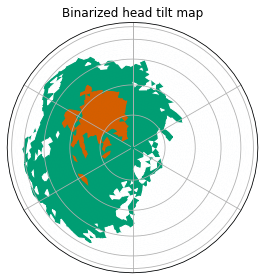

In [5]:
# Convert the histograms on the sphere in a binarized color map
colors = np.full(len(d._faces), "white", dtype="<U7")
colors[count_active != 0] = rgb[1]  # visited during active in green
colors[count_immobile != 0] = rgb[0]  # visted during immobile in red


fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection=angle_visualization.LAEA)
angle_visualization.fill_projected_faces_euclidean(
    *d.faces.transpose(2, 0, 1),
    face_colors=colors, ax=ax
)
ax.gridlines()
ax.set_title("Binarized head tilt map")
fig.tight_layout()

## Computing the features 
### Fraction of time immobile

In [6]:
fraction_time_immobile = np.sum(is_immobile) / len(is_immobile)
print(f"Fraction of time immobile:\n\t {fraction_time_immobile * 100:.2f}%")

Fraction of time immobile:
	 38.10%


### Fraction of the sphere explored during active periods 

In [7]:
# N.B.: Alternatively, you can fit a von Mises-Fisher on the data and use the fitted concentration parameter
threshold_fraction_time_spent = 1e-6
is_visited = (count_active / count_active.sum()) > threshold_fraction_time_spent
fraction_explored_active = np.sum(is_visited) / len(is_visited)

print(f"Fraction of the sphere explored during active periods:\n\t {fraction_explored_active * 100:.2f}%")

Fraction of the sphere explored during active periods:
	 35.87%


### Tilt point angle during immobility

In [8]:
# Compute the average tilt point angle from the head tilt maps
# N.B., could also be applied to the gravity estimate directly
vmf_immobile = VMF.fit(d.face_centroids, weights=count_immobile)
vmf_centroid_immobile = vmf_immobile.mu.flatten()
angle_to_xz_immobile = get_angle_x_to_xz(vmf_centroid_immobile)

print(f"Average tilt point angle to xz plane during immobility:\n\t {angle_to_xz_immobile:.2f}°")

Average tilt point angle to xz plane during immobility:
	 33.18°


### Rotation around the Z axis in an external reference frame

In [9]:
# Get the gyroscope data in an external reference frame whose Z-axis is aligned with gravity
gyr_external = Q_inv_rotate_V(df[col_quaternions].values, df[col_gyr].values)
# Convert the resulting rotation around the external Z axis in circles/min for readability
circles_per_minute_active = np.mean(gyr_external[~is_immobile, 2]) * 60 / 360

print(f"Estimate of the average number of counter-clockwise rotations per minute:\n\t {circles_per_minute_active:.2f} circles/minute")

Estimate of the average number of counter-clockwise rotations per minute:
	 0.67 circles/minute
